In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

data_path = Path('./data_and_starter_code') / 'data'
train = pd.read_csv(data_path / "train.csv")
client = pd.read_csv(data_path / "client.csv")
historical_weather = pd.read_csv(data_path / "historical_weather.csv")
forecast_weather = pd.read_csv(data_path / "forecast_weather.csv")
electricity = pd.read_csv(data_path / "electricity_prices.csv")
gas = pd.read_csv(data_path / "gas_prices.csv")

location = (pd.read_csv(data_path / "county_lon_lats.csv")
            .drop(columns=["Unnamed: 0"])
           )


In [7]:
class FeatureProcessorClass():
    def __init__(self):         
        # Columns to join on for the different datasets
        self.weather_join = ['datetime', 'county', 'data_block_id']
        self.gas_join = ['data_block_id']
        self.electricity_join = ['datetime', 'data_block_id']
        self.client_join = ['county', 'is_business', 'product_type', 'data_block_id']
        
        # Columns of latitude & longitude
        self.lat_lon_columns = ['latitude', 'longitude']
        
        # Aggregate stats 
        self.agg_stats = ['mean'] #, 'min', 'max', 'std', 'median']
        
        # Categorical columns (specify for XGBoost)
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']

    def create_new_column_names(self, df, suffix, columns_no_change):
        '''Change column names by given suffix, keep columns_no_change, and return back the data'''
        df.columns = [col + suffix 
                      if col not in columns_no_change
                      else col
                      for col in df.columns
                      ]
        return df 

    def flatten_multi_index_columns(self, df):
        df.columns = ['_'.join([col for col in multi_col if len(col)>0]) 
                      for multi_col in df.columns]
        return df
    
    def create_data_features(self, data):
        '''📊Create features for main data (test or train) set📊'''
        # To datetime
        data['datetime'] = pd.to_datetime(data['datetime'])
        
        # Time period features
        data['date'] = data['datetime'].dt.normalize()
        data['year'] = data['datetime'].dt.year
        data['quarter'] = data['datetime'].dt.quarter
        data['month'] = data['datetime'].dt.month
        data['week'] = data['datetime'].dt.isocalendar().week
        data['hour'] = data['datetime'].dt.hour
        
        # Day features
        data['day_of_year'] = data['datetime'].dt.day_of_year
        data['day_of_month']  = data['datetime'].dt.day
        data['day_of_week'] = data['datetime'].dt.day_of_week
        return data

    def create_client_features(self, client):
        '''💼 Create client features 💼'''
        # Modify column names - specify suffix
        client = self.create_new_column_names(client, 
                                           suffix='_client',
                                           columns_no_change = self.client_join
                                          )       
        return client
    
    def create_historical_weather_features(self, historical_weather):
        '''⌛🌤️ Create historical weather features 🌤️⌛'''
        
        # To datetime
        historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])
        
        # Add county
        historical_weather[self.lat_lon_columns] = historical_weather[self.lat_lon_columns].astype(float).round(1)
        historical_weather = historical_weather.merge(location, how = 'left', on = self.lat_lon_columns)

        # Modify column names - specify suffix
        historical_weather = self.create_new_column_names(historical_weather,
                                                          suffix='_h',
                                                          columns_no_change = self.lat_lon_columns + self.weather_join
                                                          ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in historical_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        historical_weather = historical_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        historical_weather = self.flatten_multi_index_columns(historical_weather) 
        
        # Test set has 1 day offset for hour<11 and 2 day offset for hour>11
        historical_weather['hour_h'] = historical_weather['datetime'].dt.hour
        historical_weather['datetime'] = (historical_weather
                                               .apply(lambda x: 
                                                      x['datetime'] + pd.DateOffset(1) 
                                                      if x['hour_h']< 11 
                                                      else x['datetime'] + pd.DateOffset(2),
                                                      axis=1)
                                              )
        
        return historical_weather
    
    def create_forecast_weather_features(self, forecast_weather):
        '''🔮🌤️ Create forecast weather features 🌤️🔮'''
        
        # Rename column and drop
        forecast_weather = (forecast_weather
                            .rename(columns = {'forecast_datetime': 'datetime'})
                            .drop(columns = 'origin_datetime') # not needed
                           )
        
        # To datetime
        forecast_weather['datetime'] = (pd.to_datetime(forecast_weather['datetime'])
                                        .dt
                                        .tz_localize(None)
                                       )

        # Add county
        forecast_weather[self.lat_lon_columns] = forecast_weather[self.lat_lon_columns].astype(float).round(1)
        forecast_weather = forecast_weather.merge(location, how = 'left', on = self.lat_lon_columns)
        
        # Modify column names - specify suffix
        forecast_weather = self.create_new_column_names(forecast_weather,
                                                        suffix='_f',
                                                        columns_no_change = self.lat_lon_columns + self.weather_join
                                                        ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in forecast_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        forecast_weather = forecast_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        forecast_weather = self.flatten_multi_index_columns(forecast_weather)     
        return forecast_weather

    def create_electricity_features(self, electricity):
        '''⚡ Create electricity prices features ⚡'''
        # To datetime
        electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])
        
        # Test set has 1 day offset
        electricity['datetime'] = electricity['forecast_date'] + pd.DateOffset(1)
        
        # Modify column names - specify suffix
        electricity = self.create_new_column_names(electricity, 
                                                   suffix='_electricity',
                                                   columns_no_change = self.electricity_join
                                                  )             
        return electricity

    def create_gas_features(self, gas):
        '''⛽ Create gas prices features ⛽'''
        # Mean gas price
        gas['mean_price_per_mwh'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh'])/2
        
        # Modify column names - specify suffix
        gas = self.create_new_column_names(gas, 
                                           suffix='_gas',
                                           columns_no_change = self.gas_join
                                          )       
        return gas
    
    def __call__(self, data, client, historical_weather, forecast_weather, electricity, gas):
        '''Processing of features from all datasets, merge together and return features for dataframe df '''
        # Create features for relevant dataset
        data = self.create_data_features(data)
        client = self.create_client_features(client)
        historical_weather = self.create_historical_weather_features(historical_weather)
        forecast_weather = self.create_forecast_weather_features(forecast_weather)
        electricity = self.create_electricity_features(electricity)
        gas = self.create_gas_features(gas)
        
        # 🔗 Merge all datasets into one df 🔗
        df = data.merge(client, how='left', on = self.client_join)
        df = df.merge(historical_weather, how='left', on = self.weather_join)
        df = df.merge(forecast_weather, how='left', on = self.weather_join)
        df = df.merge(electricity, how='left', on = self.electricity_join)
        df = df.merge(gas, how='left', on = self.gas_join)
        
        # Change columns to categorical for XGBoost
        df[self.category_columns] = df[self.category_columns].astype('category')
        return df
    
def create_revealed_targets_train(data, N_day_lags):
    '''🎯 Create past revealed_targets for train set based on number of day lags N_day_lags 🎯 '''    
    original_datetime = data['datetime']
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    # Create revealed targets for all day lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

In [8]:
# Generate features for training data
# NOTE: this can take a little bit to run
FeatureProcessor = FeatureProcessorClass()
N_day_lags = 15  # incorporate data from historical 15 days


data = FeatureProcessor(data = train.copy(),
                      client = client.copy(),
                      historical_weather = historical_weather.copy(),
                      forecast_weather = forecast_weather.copy(),
                      electricity = electricity.copy(),
                      gas = gas.copy(),
                     )

df = create_revealed_targets_train(data.copy(), 
                                  N_day_lags = N_day_lags)

In [9]:
# Save features to CSV
df.to_csv('train_features.csv', index = False)

In [10]:

df.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id', 'date',
       'year', 'quarter', 'month', 'week', 'hour', 'day_of_year',
       'day_of_month', 'day_of_week', 'eic_count_client',
       'installed_capacity_client', 'date_client', 'temperature_h_mean',
       'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean',
       'surface_pressure_h_mean', 'cloudcover_total_h_mean',
       'cloudcover_low_h_mean', 'cloudcover_mid_h_mean',
       'cloudcover_high_h_mean', 'windspeed_10m_h_mean',
       'winddirection_10m_h_mean', 'shortwave_radiation_h_mean',
       'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'hour_h',
       'hours_ahead_f_mean', 'temperature_f_mean', 'dewpoint_f_mean',
       'cloudcover_high_f_mean', 'cloudcover_low_f_mean',
       'cloudcover_mid_f_mean', 'cloudcover_total_f_mean',
       '10_metre_u_wind_component_f_mean', '10_metre_v_wind_component_f_mean',
       

In [11]:
df.head(10)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,target_6_days_ago,target_7_days_ago,target_8_days_ago,target_9_days_ago,target_10_days_ago,target_11_days_ago,target_12_days_ago,target_13_days_ago,target_14_days_ago,target_15_days_ago
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,0,3,656.859,1,2021-09-01,0,5,2,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,1,0,0.000,0,2021-09-01,0,6,3,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,1,0,59.000,1,2021-09-01,0,7,3,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,1,1,0.000,0,2021-09-01,0,8,4,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,1,1,501.760,1,2021-09-01,0,9,4,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_5777/1016523191.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['date', 'is_consumption'])['target'].sum().reset_index()


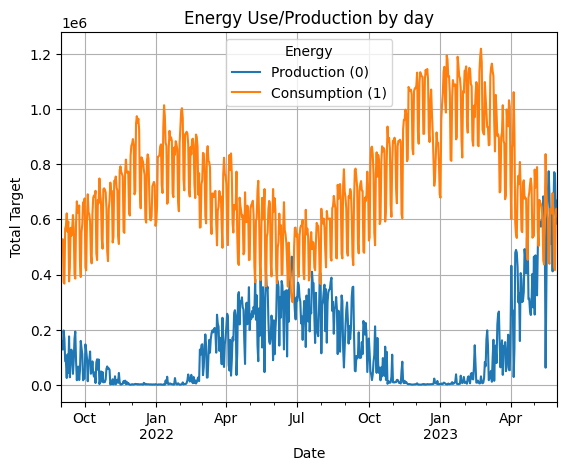

In [14]:
grouped = df.groupby(['date', 'is_consumption'])['target'].sum().reset_index()

# Pivot the data so each is_consumption value gets its own column
pivoted = grouped.pivot(index='date', columns='is_consumption', values='target')

# Plotting
pivoted.plot(kind='line')
plt.title('Energy Use/Production by day')
plt.xlabel('Date')
plt.ylabel('Total Target')
plt.legend(title='Energy', labels=['Production (0)', 'Consumption (1)'])
plt.grid(True)
plt.show()